In [1]:
import numpy as np
import pandas as pd
import igraph as ig
import vmlab

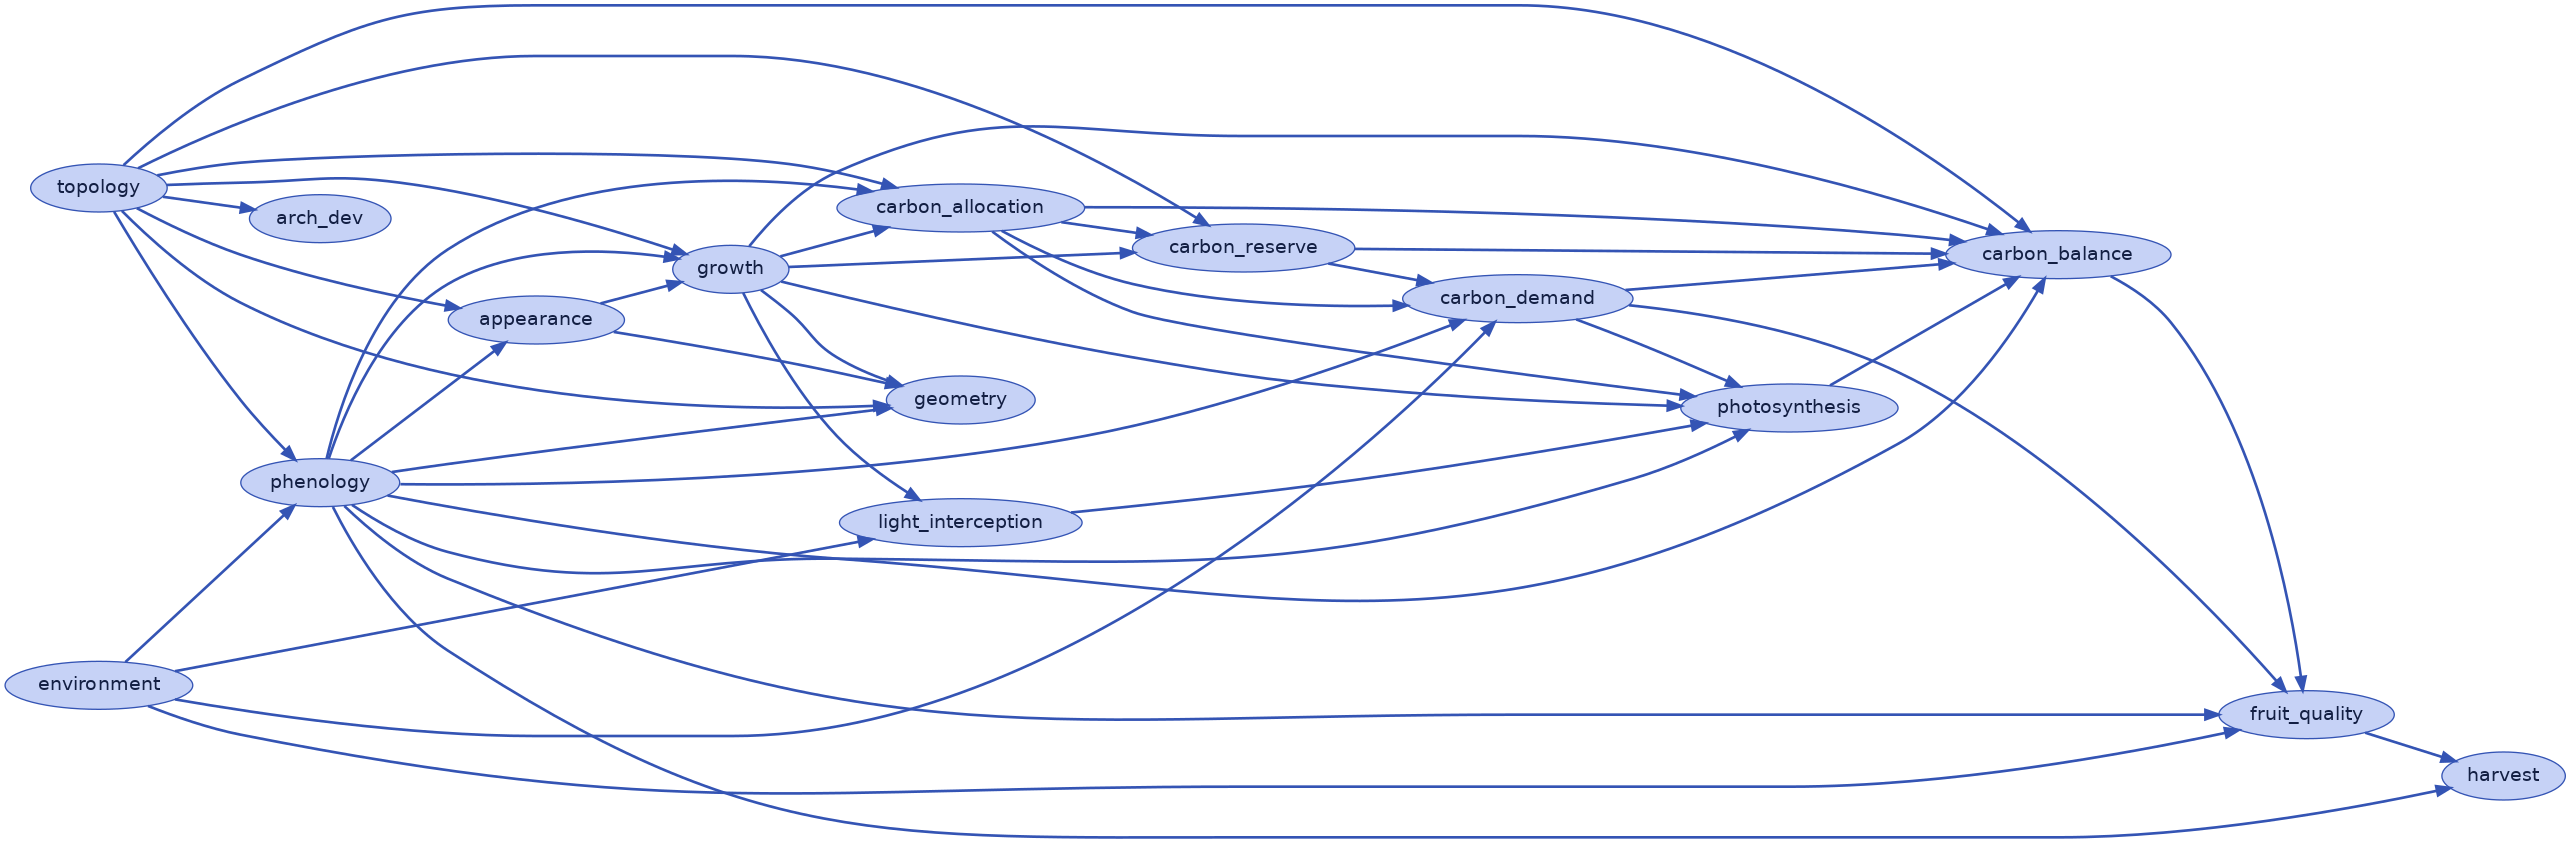

In [2]:
from vmlab.models import fruit_model
from vmlab.processes import harvest
fruit_model = fruit_model.update_processes({'harvest': harvest.HarvestByQuality})
fruit_model.visualize()

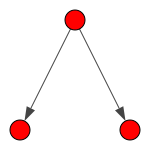

In [3]:
tree = pd.DataFrame({
    'parent_id': [np.nan, 0, 0],
    'id': [0, 1, 2],
    'cycle': [3, 3, 3],
    'is_apical': [1, 0, 1],
    'appearance_month': [2, 2, 2],
    'ancestor_nature': [0, 0, 0],
    'ancestor_is_apical': [1, 1, 1],
    'nature': [0, 0, 0],
    'burst_date': ['NAT', 'NAT', 'NAT'],
    'flowering_date': ['NAT', '2002-10-01', '2002-09-01'],
    'has_apical_child': [1, 0, 0],
    'nb_lateral_children': [1, 0, 0],
    'nb_inflo': [0, 1, 2],
    'nb_fruit': [0, 1, 1]
    
})
in_g = ig.Graph.DataFrame(tree.dropna())
ig.plot(in_g, bbox=(0,0,150,150), layout=in_g.layout_reingold_tilford())

In [4]:
setup = vmlab.create_setup(
    model=fruit_model,
    tree=tree,
    start_date='2002-06-01',
    end_date='2003-06-01',
    setup_toml='../share/setup/fruit_model.toml',
    current_cycle=3,
    input_vars={
        'topology': {
            'seed': 11,
        },
        'geometry__interpretation_freq': 3
    },
    output_vars={
        'carbon_balance': {
            'DM_fruit': 'day',
        },
        'harvest': {
            'ripeness_index': 'day'
        },
        'fruit_quality': {
            'FM_fruit': 'day',
            'DM_fleshpeel': 'day',
            'W_fleshpeel': 'day',
            'DM_flesh': 'day',
            'W_flesh': 'day',
            'flux_xylem_phloem': 'day',
            'transpiration_fruit': 'day',
            'turgor_pressure_fruit': 'day',
            'sucrose': 'day'
        }
    }
)

In [5]:
ds_out = vmlab.run(setup, fruit_model, geometry=True)

SceneWidget(scenes=[{'id': 'FhdMK73n674RMZpZRJuU7HzBU', 'data': b'x\xdaSLrw\xf5\xf7e`Pp\xe0\xe5RPVVd\x00\x020\…

             0% | initialize 

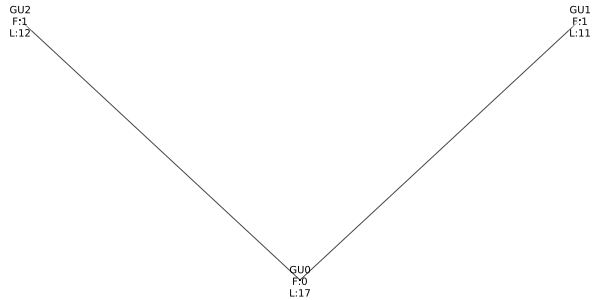

In [6]:
g = ig.Graph.Adjacency([row.tolist() for row in ds_out.topology__adjacency[-1].data.astype(np.int64)])
layout = g.layout_reingold_tilford(root=0.)
layout.rotate(-180)
ig.plot(g, layout=layout, bbox=(600, 300), **{
    'vertex_size': 1,
    'vertex_label_size': 10,
    'edge_arrow_width': 0.1,
    'vertex_label': [
        f'GU{idx}\nF:{int(ds_out.harvest__nb_fruit_harvested.data[idx])}\nL:{int(ds_out.growth__nb_leaf.data[idx])}' for idx in g.vs.indices
    ]
})

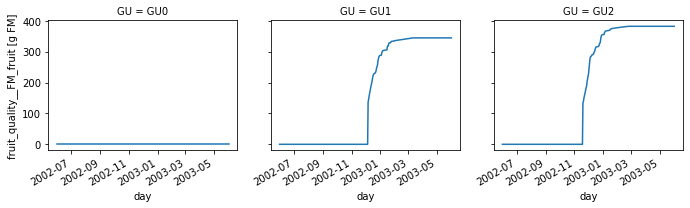

In [7]:
ds_out.fruit_quality__FM_fruit.plot(col='GU', col_wrap=6)

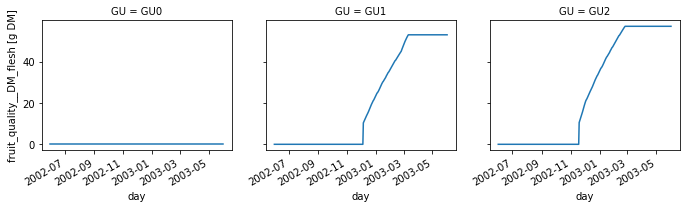

In [8]:
ds_out.fruit_quality__DM_flesh.plot(col='GU', col_wrap=6)

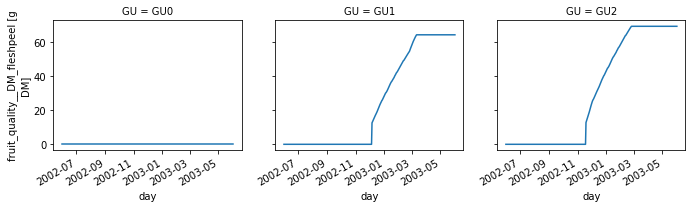

In [9]:
ds_out.fruit_quality__DM_fleshpeel.plot(col='GU', col_wrap=6)

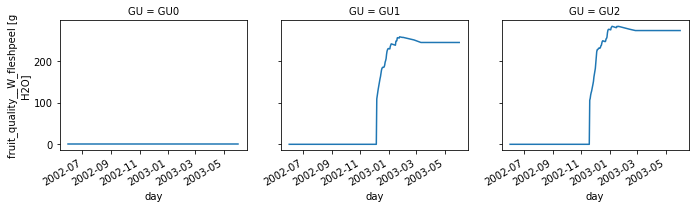

In [10]:
ds_out.fruit_quality__W_fleshpeel.plot(col='GU', col_wrap=6)

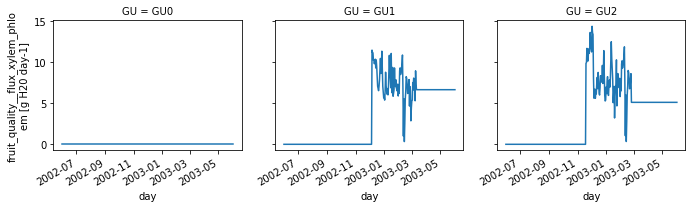

In [11]:
ds_out.fruit_quality__flux_xylem_phloem.plot(col='GU', col_wrap=6)

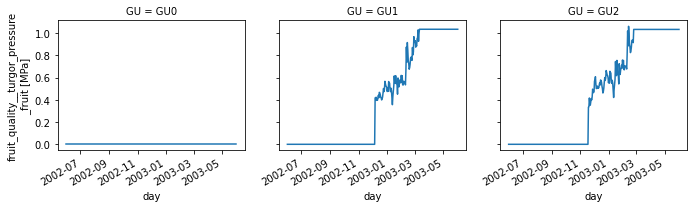

In [12]:
ds_out.fruit_quality__turgor_pressure_fruit.plot(col='GU', col_wrap=6)

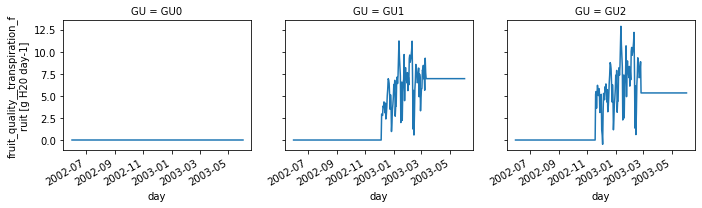

In [13]:
ds_out.fruit_quality__transpiration_fruit.plot(col='GU', col_wrap=6)

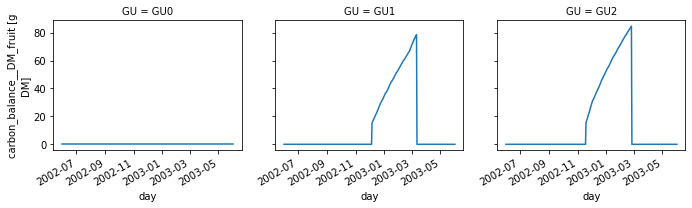

In [14]:
ds_out.carbon_balance__DM_fruit.plot(col='GU', col_wrap=6)

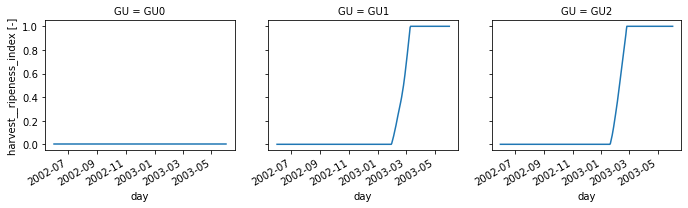

In [15]:
ds_out.harvest__ripeness_index.plot(col='GU', col_wrap=6)

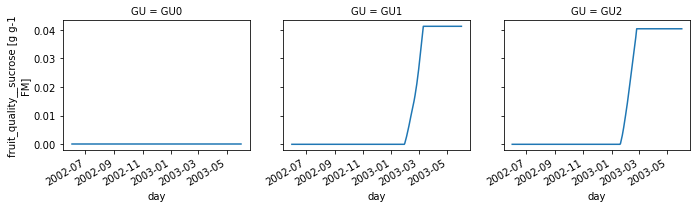

In [16]:
ds_out.fruit_quality__sucrose.plot(col='GU', col_wrap=6)